# RL homework 2
**Due date: 26nd March 2021, 4:00pm **

Name: Philip Redford-Jones

Student number: 14017791

## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<student_id>_ucldm_rl2.ipynb`** before the deadline above.

## Context

In this assignment, we will take a first look at learning algorithms for sequential decision problems.

## Background reading

* Sutton and Barto (2018), Chapters 3 - 6

# The Assignment

### Objectives

You will use Python to implement several reinforcement learning algorithms.

You will then run these algorithms on a few problems, to understand their properties.

# Setup

### Import Useful Libraries

In [1]:
import matplotlib.collections as mcoll
import matplotlib.path as mpa
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

### Set options

In [2]:
np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-colorblind')

### Some grid worlds

In [3]:
W = -100  # wall
G = 100  # goal

GRID_LAYOUT = np.array([
  [W, W, W, W, W, W, W, W, W, W, W, W],
  [W, W, 0, W, W, W, W, W, W, 0, W, W],
  [W, 0, 0, 0, 0, 0, 0, 0, 0, G, 0, W],
  [W, 0, 0, 0, W, W, W, W, 0, 0, 0, W],
  [W, 0, 0, 0, W, W, W, W, 0, 0, 0, W],
  [W, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, W],
  [W, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, W],
  [W, W, 0, 0, 0, 0, 0, 0, 0, 0, W, W],
  [W, W, W, W, W, W, W, W, W, W, W, W]
])

class Grid(object):

  def __init__(self, noisy=False):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = GRID_LAYOUT
    self._start_state = (2, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._noisy = noisy

  @property
  def number_of_states(self):
      return self._number_of_states

  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x

  def obs_to_state(self, obs):
    x = obs % self._layout.shape[1]
    y = obs // self._layout.shape[1]
    s = np.copy(grid._layout)
    s[y, x] = 4
    return s

  def step(self, action):
    y, x = self._state
    
    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    reward = self._layout[new_y, new_x]
    if self._layout[new_y, new_x] == W:  # wall
      discount = 0.9
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = -1.
      discount = 0.9
    else:  # a goal
      discount = 0.
      new_state = self._start_state

    if self._noisy:
      width = self._layout.shape[1]
      reward += 10*np.random.normal(0, width - new_x + new_y)

    self._state = new_state
    return reward, discount, self.get_obs()

  def plot_grid(self):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout != W, interpolation="nearest", cmap='pink')
    plt.gca().grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(2, 2, r"$\mathbf{S}$", ha='center', va='center')
    plt.text(9, 2, r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)


In [4]:
SMALL_GRID_LAYOUT = np.array([
  [W, W, W, W, W],
  [W, W, 3, W, W],
  [W, W, 0, W, W],
  [W, 1, 0, W, W],
  [W, W, 0, W, W],
  [W, W, 0, 4, W],
  [W, W, W, W, W]
])


def plot_small_grid(version=1):
  plt.imshow(SMALL_GRID_LAYOUT < -1, interpolation='nearest', cmap='pink_r',
             vmin=-0.2, vmax=1.2)
  if version == 1:
    plt.text(2, 1, '$+3$', ha='center', va='center', fontsize=12)
    plt.text(1, 3, '$+1$', ha='center', va='center', fontsize=12)
    plt.text(3, 5, '$+4$', ha='center', va='center', fontsize=12)
  else:
    plt.text(2, 1, '$+2$', ha='center', va='center', fontsize=12)
    plt.text(1, 3, '$+1$', ha='center', va='center', fontsize=12)
    plt.text(3, 5, '$+5$', ha='center', va='center', fontsize=12)
  plt.text(2, 3, '$S$', ha='center', va='center', fontsize=12)
  h, w = SMALL_GRID_LAYOUT.shape
  for r in np.arange(0.5, h):
    plt.plot([-0.5, w - 0.5], [r, r], '-k', lw=3, alpha=0.4)
  for c in np.arange(0.5, w):
    plt.plot([c, c], [-0.5, h - 0.5], '-k', lw=3, alpha=0.4)
  plt.xticks([]); plt.yticks([]);

### Helper functions
(You should not have to change, or even look at, these.  Do run the cell to make sure the functions are loaded though.)

In [5]:
def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = grid.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += reward
    return mean_reward/float(number_of_steps)

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_values(grid, values, colormap='pink', vmin=0, vmax=10):
  plt.imshow(values - 1000*(grid<0), interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_action_values(grid, action_values, vmin=-5, vmax=5):
  q = action_values
  fig = plt.figure(figsize=(10, 10))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  for a in [0, 1, 2, 3]:
    plt.subplot(4, 3, map_from_action_to_subplot(a))
    plot_values(grid, q[..., a], vmin=vmin, vmax=vmax)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(4, 3, 5)
  v = np.max(q, axis=-1)
  plot_values(grid, v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")
  
  # Plot arrows:
  plt.subplot(4, 3, 11)
  plot_values(grid, grid==0, vmax=1)
  for row in range(len(grid)):
    for col in range(len(grid[0])):
      if grid[row][col] == 0:
        argmax_a = np.argmax(q[row, col])
        if argmax_a == 0:
          x = col
          y = row + 0.5
          dx = 0
          dy = -0.8
        if argmax_a == 1:
          x = col - 0.5
          y = row
          dx = 0.8
          dy = 0
        if argmax_a == 2:
          x = col
          y = row - 0.5
          dx = 0
          dy = 0.8
        if argmax_a == 3:
          x = col + 0.5
          y = row
          dx = -0.8
          dy = 0
        plt.arrow(x, y, dx, dy, width=0.02, head_width=0.4, head_length=0.4, length_includes_head=True, fc='k', ec='k')

def plot_rewards(xs, rewards, color):
  mean = np.mean(rewards, axis=0)
  p90 = np.percentile(rewards, 90, axis=0)
  p10 = np.percentile(rewards, 10, axis=0)
  plt.plot(xs, mean, color=color, alpha=0.6)
  plt.fill_between(xs, p90, p10, color=color, alpha=0.3)

def parameter_study(parameter_values, parameter_name,
  agent_constructor, env_constructor, color, repetitions=10, number_of_steps=int(1e4)):
  mean_rewards = np.zeros((repetitions, len(parameter_values)))
  greedy_rewards = np.zeros((repetitions, len(parameter_values)))
  for rep in range(repetitions):
    for i, p in enumerate(parameter_values):
      env = env_constructor()
      agent = agent_constructor()
      if 'eps' in parameter_name:
        agent.set_epsilon(p)
      elif 'alpha' in parameter_name:
        agent._step_size = p
      else:
        raise NameError("Unknown parameter_name: {}".format(parameter_name))
      mean_rewards[rep, i] = run_experiment(grid, agent, number_of_steps)
      agent.set_epsilon(0.)
      agent._step_size = 0.
      greedy_rewards[rep, i] = run_experiment(grid, agent, number_of_steps//10)
      del env
      del agent

  plt.subplot(1, 2, 1)
  plot_rewards(parameter_values, mean_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Average reward over first {} steps".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

  plt.subplot(1, 2, 2)
  plot_rewards(parameter_values, greedy_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Final rewards, with greedy policy".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

def epsilon_greedy(q_values, epsilon):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])


def colorline(x, y, z):
    """
    Based on:
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """
    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=plt.get_cmap('copper_r'),
                              norm=plt.Normalize(0.0, 1.0), linewidth=3)

    ax = plt.gca()
    ax.add_collection(lc)
    return lc


def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments


def plotting_helper_function(_x, _y, title=None, ylabel=None):
  z = np.linspace(0, 0.9, len(_x))**0.7
  colorline(_x, _y, z)
  plt.plot(0, 0, '*', color='#000000', ms=20, alpha=0.7, label='$w^*$')
  plt.plot(1, 1, '.', color='#ee0000', alpha=0.7, ms=20, label='$w_0$')
  min_y, max_y = np.min(_y), np.max(_y)
  min_x, max_x = np.min(_x), np.max(_x)
  min_y, max_y = np.min([0, min_y]), np.max([0, max_y])
  min_x, max_x = np.min([0, min_x]), np.max([0, max_x])
  range_y = max_y - min_y
  range_x = max_x - min_x
  max_range = np.max([range_y, range_x])
  plt.arrow(_x[-3], _y[-3], _x[-1] - _x[-3], _y[-1] - _y[-3], color='k',
            head_width=0.04*max_range, head_length=0.04*max_range,
            head_starts_at_zero=False)
  plt.ylim(min_y - 0.2*range_y, max_y + 0.2*range_y)
  plt.xlim(min_x - 0.2*range_x, max_x + 0.2*range_x)
  ax = plt.gca()
  ax.ticklabel_format(style='plain', useMathText=True)
  plt.legend(loc=2)
  plt.xticks(rotation=12, fontsize=10)
  plt.yticks(rotation=12, fontsize=10)
  plt.locator_params(nbins=3)
  if title is not None:
    plt.title(title, fontsize=20)
  if ylabel is not None:
    plt.ylabel(ylabel, fontsize=20)
  

# Section 1: Tabular RL _(60 pts in total for the whole section)_

In this section, observations will be states in the environment, so the agent state, environment state, and observation will all be the same, and we will use the word `state` interchangably with `observation`.  You will implement agents, which should be in pure Python - so you cannot use JAX/TensorFlow/PyTorch to compute gradients. Using `numpy` is fine.

## Q1: A small grid world _(10 pts in total)_

Consider the grid MDP below:

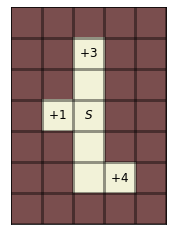

In [6]:
plot_small_grid()

The agent starts at the state marked $S$, and  can move up, left, right, or down.  Whenever it enters a cell with a positive number, the agent receives that reward and the episode terminates.
### Q1.1 [**3 pts**]
Use the code below to plot the value of the optimal policy from the starting state, $v_*(S)$, as a function of the discount factor $\gamma$.

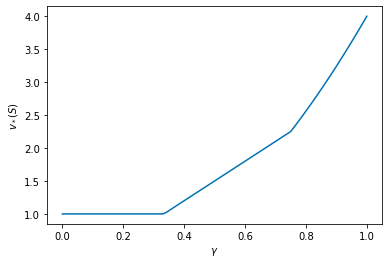

In [7]:
def v(discount):
  # The value of the optimal policy is the dicounted sum of rewards for each state
  # v_*(S_{t}) = R_{t+1} + discount * (v_*(S_{t+1}))
  # Stepping left will give an instant reward of 1
  action_1 = 1
  # Moving up gives no instant reward but discountented reward from next step
  action_3 = 0 + discount * 3
  # Moving down gives no rewards for first 2 then doubly discounted reward from 3rd step
  action_4 = 0 + 0 + (discount ** 2) * 4 
  
  # No need to consider agent moving back on itself as this is suboptimal
  # We can see from the plot that when discounting is high (close to 0) 
  # the agent acts very shortsighted and select the instant reward action
  # Return the action with the highest discounted value
  return max(action_1, action_3, action_4)

# Don't change this function
def plot_v():
  discounts = np.arange(0, 1.001, 0.01)
  plt.plot(discounts, [v(g) for g in discounts])
  plt.xlabel('$\gamma$')
  plt.ylabel('$v_*(S)$')

plot_v()

### Q1.2 [**2 pts**]

Specify the optimal policy, as a function of $\gamma$.

### Answer

$$
  v_*(s) = \max_{a} \mathbb{E}[R_{t+1} + \gamma v_*(s_{t+1}) | S_t=s, A_t=a]
$$

Substituting in the values of moving directly to the end goal,

$$
  v_*(s_{\to +1}) < v_*(s_{\to +3})
$$
$$
   1 < 3 \gamma
$$
Rearanging
$$
  1/3 < \gamma
$$
Thus while $\gamma$ is less than 1/3 the optimal policy is to go to reward +1. Comparing +3 to +4 we see:
$$
  v_*(s_{\to +3}) < v_*(s_{\to +4})
$$
$$
  3 \gamma < 4 \gamma^2
$$
Rearanging
$$
  3/4 <  \gamma
$$
Therfore while $\gamma$ is greater than 3/4 the optimal policy is to go to reward +4.

Thus the optimal policy as a function of $\gamma$:
$$
v_*(s) = \begin{cases}
v_*(s_{\to +1}) & \text{for }{\gamma < 1/3} \\
v_*(s_{\to +3}) & \text{for }{1/3 \le \gamma < 3/4} \\
v_*(s_{\to +4}) & \text{for }{3/4 \le \gamma} \\
\end{cases}
$$

### Q1.3 [**2 pts**]
Consider the variation of this problem shown in the next plot.

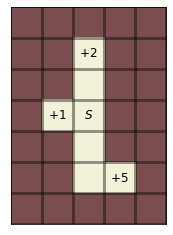

In [8]:
plot_small_grid(version=2)

Suppose a behavioural scientist was doing an experiment where they gave rewards to an animal.  Suppose the setting was as depicted above, where the rewards for instance correspond to food or some other kind of treat (e.g., 5 food pellets at the location marked $+5$). It turns out that, after repeatedly exploring the grid, the animal seems to prefer going up to the reward of $+2$.

Prove that in the MDP depicted above no scalar discount $\gamma \in [0, 1]$ exists for which the optimal policy is to go to $+2$.

### Answer
Comparing the expected value of going to either +2 or +5 reward following an optimal policy. 
$$
  v_*(s_{\to +2}) > v_*(s_{\to +5})
$$
$$
   2\gamma > 5 \gamma^2
$$
Rearanging
$$
  2/5 > \gamma
$$
$$
  0.4 > \gamma
$$

Here we can see that when $\gamma$ is less than 0.4, the agent/animal will prefer to go to the reward of 2, rather than the reward of 5. 

But when we set this value we see the expected value for going to +2 reward we see:

$$
  v_*(s_{\to +2}) = 0.4 \times 2 = 0.8
$$

But the reward for going to the +1 state is always 1 as it is independent of $\gamma$, 

$$
  v_*(s_{\to +1}) = 1.0
$$

Therefore the animal will always choose either reward 1 or 5. 


### Q1.4 [**3 pts**]
In the same setting as the previous question, now consider the following generalised definition of a Monte Carlo return
\begin{align*}
G_t
& = R_{t+1} + f(R_{t+2} + f(R_{t+3} + f(\ldots))) \\
& = R_{t+1} + f(G_{t+1}) \,,
\end{align*}
In this formulation, we get standard discounting when we define $f(x) = \gamma x$. Consider the following alternative where instead of multiplying with a factor $\gamma$, we raise the value to the power: $f(x) = x^\gamma$.  Does this mathematical model better explain the observed behaviour, in the sense that a $\gamma$ exists for which the optimal policy goes to $+2$?  If so, give such a value for $\gamma$, and prove that the policy of going to $+2$ is optimal with that choice.  If not, prove that no such $\gamma$ exists.


### Answer

We have that the new value function is:

$$
  v_*(s) = R_{t+1} + v_*(s_{t+1})^{\gamma}
$$

Thus we can see for each reward value following the optimal policy:

$$
  v_*(s_{\to +1}) = 1
$$
$$
  v_*(s_{\to +2}) = 2^{\gamma}
$$
$$
  v_*(s_{\to +5}) = 5^{\gamma^2}
$$

Camparing +1 to +2

$$
  2^{\gamma} \ge 1
$$
$$
  {\gamma} \ln(2) \ge \ln(1)
$$
$$
  {\gamma} \ge 0
$$

Therefore the agent will go to plus 2 for any $\gamma$ greater than 0. At zero, all values are equal, thus assuming we break ties evenly, we would expect the animal/agent to go to +1 33% of the time when the discount is 0. 

Comparing +2 to +5

$$
  2^{\gamma} \le 5^{\gamma^2}
$$
$$
  {\gamma} \ln(2) \le \gamma^2 \ln(5)
$$
$$
  \ln(2) \le \gamma \ln(5)
$$
$$
  \ln(2) / \ln(5)  \le \gamma
$$
$$
  0.43 \le \gamma
$$

Therefore when $\gamma$ is less than 0.43 and greater than 0, the agent/animal will go to the +2 reward. The agent will go to the +5 reward for any $\gamma > 0.43$.

# Implementing algorithms

**Minimal agent interface**:

Each agent should implement the following methods:

### `__init__(self, number_of_actions, number_of_states, initial_observation, ...)`:
The constructor will provide the agent the number of actions, number of states, and the initial state. You can get the initial state by first instatiating an environment, using `grid = Grid()`, and then calling `grid.get_obs()`. The constructor may accept additional arguments (denoted here by the ellipsis `...`) depending on the specific algorithm implemented by the agent.

### `step(self, reward, discount, next_state)`:

The step method of an agent should update its internals, in whatever way is appropriate for its learning algorithm, and return a new action to be executed in the environment.

When the discount is zero ($\text{discount} = \gamma = 0$), then the `next_state` will be the initial observation of the next episode.  One shouldn't bootstrap on the value of this state, which can simply be guaranteed when using "$\gamma \cdot v(\text{next_state})$" in the update, because $\gamma = 0$ (for whatever definition of $v$ is appropriate---for instance, $v(s)$ could be defined in terms of action values estimates that we are learning, for instance by $v(s) = \max_a q(s, a)$).  Therefore, the end of an episode can be seamlessly handled with the same step function.

**Note on the initial action**:

Some algorithms (Q-learning, Sarsa) need to remember the last action in order to update its value when they see the next state and reward.  In the constructor (`__init__`), make sure you set the initial action to zero, e.g.,
```
def __init__(...):
  (...)
  self._last_action = 0
  (...)
```
In our experiments the helper functions above will execute the action `0` (which corresponds to `up` in the grid world) as the initial action to begin the run loop of the experiment.  This initial action is only executed once, and the beginning of the very first episode---not at the beginning of each episode.

### A random agent

Below we show a reference implementation of a simple random agent, implemented according to the interface above.

In [9]:
class Random(object):

  def __init__(self, number_of_actions, number_of_states, initial_state):
    self._number_of_actions = number_of_actions

  def step(self, reward, discount, next_state):
    next_action = np.random.randint(self._number_of_actions)
    return next_action

### The grid

The cell below shows the `Grid` environment that we will use in this section. Here `S` indicates the start state and `G` indicates the goal.  The agent has four possible actions: up, right, down, and left.  Rewards are: `-100` for bumping into a wall, `+100` for reaching the goal, and `-1` otherwise.  The episode ends when the agent reaches the goal, and otherwise continues.  The discount, on continuing steps, is $\gamma = 0.9$.  Feel free to reference the implemetation of the `Grid` above, under the header "a grid world".

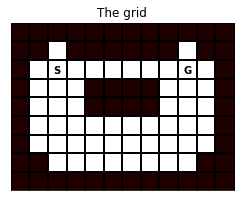

In [10]:
grid = Grid()
grid.plot_grid()


## Q2: Implement TD learning **[5 pts]**
Implement an agent that acts randomly, and _on-policy_ estimates state values $v(s)$, using one-step TD learning with step size $\alpha=0.1$.

In addition to the base interface, also implement a property `state_values(self)` returning the vector of all state values (one value per state).

You should be able to use the `__init__` as provided below, so you just have to implement the `step` function.  We store the initial state in the constructor because you need its value on the first `step` in order to compute the TD error when the first transition has occurred.  

**Hint**: in the `step` you similarly will want to store the previous state to be able to compute the next TD error on the next step.


In [11]:
class RandomTD(object):

  def __init__(self, number_of_states, number_of_actions, initial_state, step_size=0.1):
    self._values = np.zeros(number_of_states)
    self._state = initial_state
    self._number_of_actions = number_of_actions
    self._step_size = step_size

  @property
  def state_values(self):
    return self._values

  def step(self, reward, discount, next_state):
    
    # Update the value using step size and TD
    TD = reward + discount * self._values[next_state] - self._values[self._state]
    self._values[self._state] += self._step_size * TD
    # Update the current state to the next state
    self._state = next_state

    # Returning a random action because random policy
    return np.random.randint(0, self._number_of_actions)

### Run the next cell to run the `RandomTD` agent on a grid world.

If everything worked as expected, the plot below will show the estimates state values under the random policy. This includes values for unreachable states --- on the walls and on the goal (we never actually reach the goal --- rather, the episode terminates on the transition to the goal.  The values on the walls and goal are, and will always remain, zero (shown in orange below).

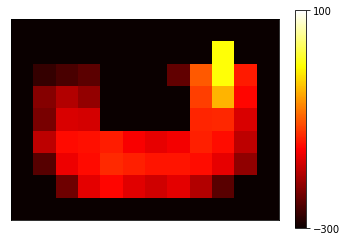

In [12]:
# Do not modify this cell.
agent = RandomTD(grid._layout.size, 4, grid.get_obs())
run_experiment(grid, agent, int(1e5))
v = agent.state_values
plot_values(GRID_LAYOUT, v.reshape(grid._layout.shape), colormap="hot", vmin=-300, vmax=100)

## Q3: Policy iteration **[5 pts]**
We used TD to do policy evaluation for the random policy on this problem.  Consider doing policy improvement, by taking the greedy policy with respect to a one-step look-ahead.  For this, you may assume we have a true model, so for each state and for each action we can look at the value of the resulting state, and would then pick the action with the highest reward plus subsequent state value. In other words, you can assume we can use $q(s, a) = \mathbb{E}[ R_{t+1} + \gamma v(S_{t+1}) \mid S_t = s, A_t = a]$, where $v$ is the value function learned by TD as implemented. Then we consider the policy that picks the action with the highest action value $q(s, a)$. You do **not** have to implement this, just answer the following question.

The above amounts to performing an iteration of policy evaluation and policy improvement.  If we repeat this process over and over again, and repeatedly evaluate the greedy policy and then perform an improvement step by picking the greedy policy, would the policy eventually become optimal?  Explain why or why not in at most three sentences.

> There is no guarantee that the policy will converge to the optimal policy (moving straight through the corridor) as we are selecting and evaluating all actions based on a greedy policy. Thus not all states will be visited, nor will all actions be selected, and a potentially better state-action may never be selected or evaluated. From the RandomTD plot, we can see that the agent values the states along the longer path higher than those along the optimal shorter corridor path; thus, the action moving to these states will be selected. 


## Q4: Implement a general Q-learning agent **[15 pts]**
Implement a  **general Q-learning** agent that learns action values from experience.   The agent must act according to an $\epsilon$-greedy policy over its action values.  It must be configurable so as to implement any of **Sarsa**, **Expected Sarsa**, **Q-learning**,  and **double Q-learning**.

The `__init__` must accept two functions `target_policy` and `behaviour_policy` as arguments.   The function `behaviour_policy(action_values)` should map `action_values` to a single action. 

For instance, the random policy can be implemented as:
```
def behaviour_policy(action_values):
  return np.random.randint(len(action_values))
```

The target policy is defined by a function `target_policy(action_values, action)`, which returns **a vector** with one probability per action.  The `action` argument is used for instance by Sarsa (where the target policy is a greedy distribution with its peak on the selected action).

For instance, the random target policy is:
```
def target_policy(action_values, unused_action):
  number_of_actions = len(action_values)
  return np.ones((number_of_actions,))/number_of_actions
```

The `__init__` must also accept  a `double` boolean flag. Note that this is compatible with any choice of `target_policy` and `behaviour_policy`. For instance, if the `target_policy` is the policy described above for Sarsa and `double=True`, the algorithm should implement **double Sarsa**. Note that we then need two action-value functions.

You should be able to use the `__init__` as provided below, so you just have to implement the `step` function.  We store the initial state in the constructor because you need its value on the first `step` in order to compute the update on the first transition in the agent's lifetime.  


In [13]:
class GeneralQ(object):

  def __init__(self, number_of_states, number_of_actions, initial_state,
               target_policy, behaviour_policy, double, step_size=0.1):
    # Settings.
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._target_policy = target_policy
    self._double = double
    # Initial state.
    self._s = initial_state
    # Tabular q-estimates.
    self._q = np.zeros((number_of_states, number_of_actions))
    if double:
      self._q2 = np.zeros((number_of_states, number_of_actions))
    # The first action in an agent's lifetime is always 0(=up) in our setup.
    self._last_action = 0

  @property
  def q_values(self):
    return (self._q + self._q2)/2 if self._double else self._q

  def step(self, reward, discount, next_state):
    """
    Selects an action based on the bahaviour policy 
    Updates the bahaviour policy based on past state-action

    Key-point: most target policies only select actions based on state, 
    rather than the next action also.  

    Inputs
    reward: the reward recieved after taking the previous action
    discount: the discount rate that we apply to expected future values
    next_state: the agent's state after it has taken the previous action

    Outputs
    action: the action selected by the behaviour policy
    """

    # If using double learning 
    if self._double:
      # Update Q1 with 50% probabilty 
      if np.random.random() < 0.5:
        # Calculate the td error using q1 to select the nect action
        # And q2 to evalute the state action - reversed for other
        next_action = self._behaviour_policy((self._q[next_state] + self._q2[next_state]) / 2)
        # next_action = self._behaviour_policy(self._q[next_state])
        # Calculate the td error using q1 selected action with q2 evaluation
        action_probs = self._target_policy(self._q[next_state], next_action)
        
        # Updated using expectation to break ties
        target_q = np.sum(action_probs * self._q2[next_state])
        td_error = reward + discount * target_q - self._q[self._s, self._last_action]

        # Update the q values using step size and td error
        self._q[self._s, self._last_action] += self._step_size * td_error
        # Select an action based on behaviour policy for next state
        action = next_action
        
      # Update Q2 with 50% probabilty 
      else: 
        # Same as above but swapped q for q2
        next_action = self._behaviour_policy((self._q[next_state] + self._q2[next_state]) / 2)
        # next_action = self._behaviour_policy(self._q2[next_state])
        action_probs = self._target_policy(self._q2[next_state], next_action)

        # Updated using expectation to break ties
        target_q = np.sum(action_probs * self._q[next_state])
        td_error = reward + discount * target_q - self._q2[self._s, self._last_action]

        self._q2[self._s, self._last_action] += self._step_size * td_error
        action = next_action

    # Otherwise if not double Q just using a single q value
    else:

      # For SARSA we need to select an on policy action for the target policy
      next_action = self._behaviour_policy(self._q[next_state])
      # We feed the next state and action into the target policy get the target policy action
      action_probs = self._target_policy(self._q[next_state], next_action)
      # Take the expectation (action probs are zero for one hot vectors)
      target_q = np.sum(action_probs * self._q[next_state])

      # Calculate the temperal difference error using these values
      td_error = reward + discount * target_q - self._q[self._s, self._last_action]
      # Update the q values using step size and td error
      self._q[self._s, self._last_action] += self._step_size * td_error
      # Select an action based on behaviour policy for next state
      action = next_action
    
    # Set the last action and state to next action and state
    self._last_action = action
    self._s = next_state
    
    return action

## Experiment 1: Run the cells below

This will train Q-learning, Sarsa, Expected Sarsa, and double Q-learning agents on the deterministic version of the Grid problem.

The agents will be trained  with a step size $\alpha=\frac{1}{10}$ and $\epsilon$-greedy behaviour, with $\epsilon=\frac{1}{4}$.

The plots will show action values for each of the actions, as well as a state value defined by $v(s) = \max_a q(s, a)$.

In [14]:
# Agent settings.
# Do not modify this cell.
epsilon = 0.25
step_size = 0.1

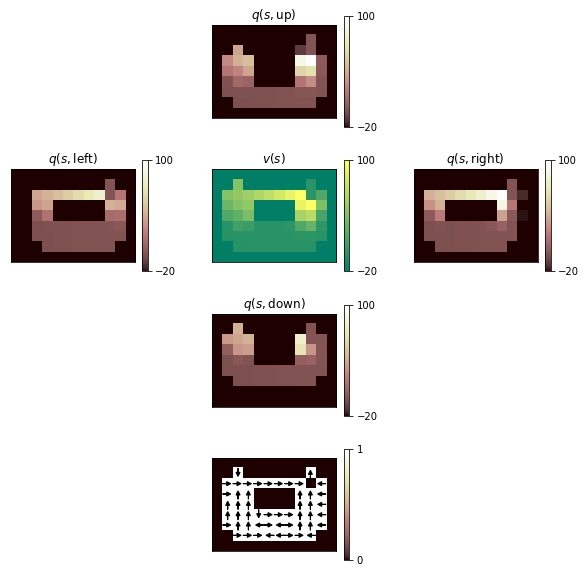

In [15]:
# Q-learning
# Do not modify this cell.
def behaviour_policy(q):
  return epsilon_greedy(q, epsilon)
def target_policy(q, a):
  return np.eye(len(q))[np.argmax(q)]

learned_qs = []
for _ in range(5):
  grid = Grid()
  agent = GeneralQ(grid._layout.size, 4, grid.get_obs(), target_policy, 
                   behaviour_policy, double=False, step_size=step_size)
  run_experiment(grid, agent, int(1e5))
  learned_qs.append(agent.q_values.reshape(grid._layout.shape + (4,)))
  
avg_qs = sum(learned_qs)/len(learned_qs)
plot_action_values(GRID_LAYOUT, avg_qs, vmin=-20, vmax=100)

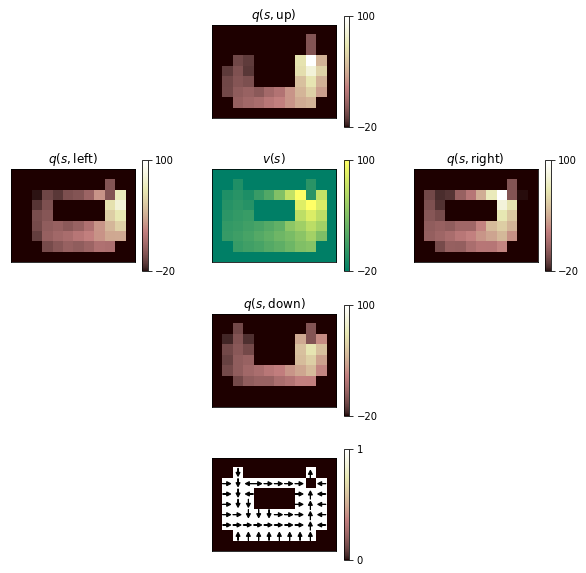

In [16]:
# Sarsa
# Do not modify this cell.
def behaviour_policy(q):
  return epsilon_greedy(q, epsilon)
def target_policy(q, a):
  return np.eye(len(q))[a]

learned_qs = []
for _ in range(5):
  grid = Grid()
  agent = GeneralQ(grid._layout.size, 4, grid.get_obs(), target_policy, 
                   behaviour_policy, double=False, step_size=step_size)
  run_experiment(grid, agent, int(1e5))
  learned_qs.append(agent.q_values.reshape(grid._layout.shape + (4,)))
  
avg_qs = sum(learned_qs)/len(learned_qs)
plot_action_values(GRID_LAYOUT, avg_qs, vmin=-20, vmax=100)

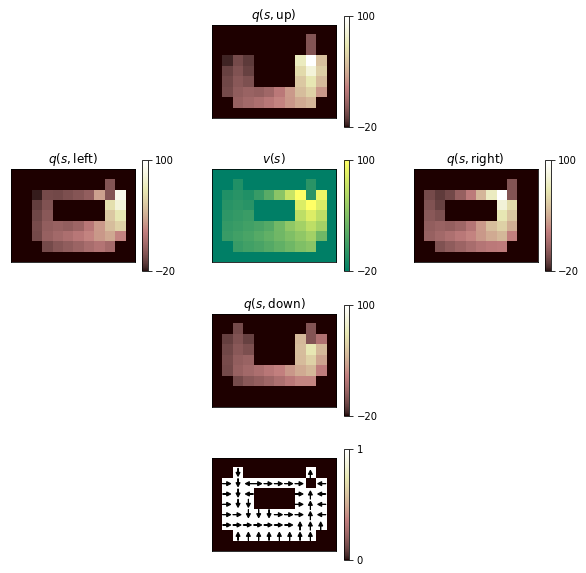

In [17]:
# Expected Sarsa
# Do not modify this cell.
grid = Grid()
def behaviour_policy(q):
  return epsilon_greedy(q, epsilon)
def target_policy(q, a):
  greedy = np.eye(len(q))[np.argmax(q)]
  return greedy - greedy*epsilon + epsilon/4 

learned_qs = []
for _ in range(5):
  grid = Grid()
  agent = GeneralQ(grid._layout.size, 4, grid.get_obs(), target_policy, 
                   behaviour_policy, double=False, step_size=step_size)
  run_experiment(grid, agent, int(1e5))
  learned_qs.append(agent.q_values.reshape(grid._layout.shape + (4,)))
  
avg_qs = sum(learned_qs)/len(learned_qs)
plot_action_values(GRID_LAYOUT, avg_qs, vmin=-20, vmax=100)

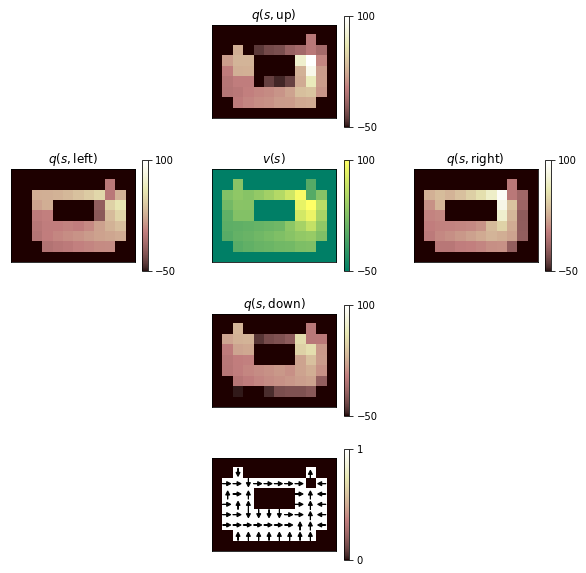

In [27]:
# Double Q-learning
# Do not modify this cell.
def behaviour_policy(q):
  return epsilon_greedy(q, epsilon)
def target_policy(q, a):
  # Place equal probability on all actions that achieve the `max` value.
  # This is equivalent to `return np.eye(len(q))[np.argmax(q)]` for Q-learning
  # But results in slightly lower variance updates for double Q.
  max_q = np.max(q)
  pi = np.array([1. if qi == max_q else 0. for qi in q])
  return pi / sum(pi)

learned_qs = []
for _ in range(5):
  grid = Grid()
  agent = GeneralQ(grid._layout.size, 4, grid.get_obs(), target_policy, 
                   behaviour_policy, double=True, step_size=step_size)
  run_experiment(grid, agent, int(1e5))
  learned_qs.append(agent.q_values.reshape(grid._layout.shape + (4,)))
  
avg_qs = sum(learned_qs)/len(learned_qs)
plot_action_values(GRID_LAYOUT, avg_qs, vmin=-50, vmax=100)

## Q5: Analyse results _(10 pts in total)_

Consider the greedy policy with respect to the estimated values learned by each of the four agents.

**[5 pts]** How and why do the policies found by Q-learning, Sarsa, Expected Sarsa, and double Q-learning differ? Explain notable qualitative differences in at most four sentences.
 
> Q-learning reliably found the most direct path to the target (through the corridor), with Double Q-learning also finding the path, but less reliably over many runs. Q-Learning selects the target action using a pure greed approach, thus enabling it to select the action to continue down the corridor, with Double Q-Learning acting similarly but less prone to overestimating the value of this corridor path. SARSA and Expected SARSA both learn similar 'cautious' policies, learning to travel the longer route to the target rather than the corridor path. This sub-optimal route is due to both approaches selecting the target action using some element of probability/randomness; thus, the agent struggles to learn the long straight path through the corridor.

**[5 pts]** Which of the algorithms, out of Q-learning, Sarsa, Expected Sarsa, and double Q-learning with the learning parameters (exploration, step size) as discussed above, will *in general* yield higher returns on average during learning?  You are allowed to specify a partial (rather than a full) ordering over the algorithms, but try to be as specfic as you can. Explain your answer in at most four sentences.

> Double Q-Learning will, in general, perform better on GridWorld problems as it tends not to overestimate state-action values, as opposed to Q-learning, which tends to overestimate values, leading to 'riskier' policies as shown by its preference for the corridor path in this experiment. Similarly, we find Expected SARSA tends to improve on SARSA, with Expected SARSA evaluating target states using the state's expected value rather than the maximising action value. Expected SARSA reduces the variance in state evaluation significantly, thus improving stability and convergence. In general, Expected SARSA and Double Q-Learning would lead to better and similar performance, reducing variance and value overestimation compared to their simpler versions. 

## Experiment 2: Run the cells below

This will train Q-learning and double Q-learning agents on the stochastic version of the Grid problem.

In the noisy version, a zero-mean Gaussian is added to all rewards.  

The variance of this noise is higher the further to the left you go, and the further down.

The agents will be trained  with a step size $\alpha=\frac{1}{10}$ and $\epsilon$-greedy behaviour, with $\epsilon=\frac{1}{4}$.

The plots will show action values for each of the actions, as well as a state value defined by $v(s) = \max_a q(s, a)$.

In [19]:
# Agent settings.
# Do not modify this cell.
epsilon = 0.25
step_size = 0.1

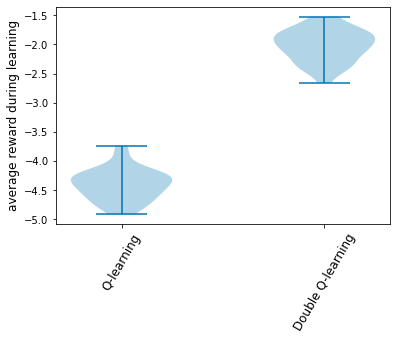

In [20]:
# Q-learning and double Q-learning.
# Do not modify this cell.

def target_policy(q, a):
  max_q = np.max(q)
  pi = np.array([1. if qi == max_q else 0. for qi in q])
  return pi / sum(pi)

def behaviour_policy(q):
  return epsilon_greedy(q, epsilon)

mean_reward_q_learning = []
mean_reward_double_q_learning = []
for _ in range(30):
  grid = Grid(noisy=True)
  q_agent = GeneralQ(
      grid._layout.size, 4, grid.get_obs(),
      target_policy, behaviour_policy, double=False, step_size=step_size)
  dq_agent = GeneralQ(
      grid._layout.size, 4, grid.get_obs(),
      target_policy, behaviour_policy, double=True, step_size=step_size)
  mean_reward_q_learning.append(run_experiment(grid, q_agent, int(2e5)))
  mean_reward_double_q_learning.append(run_experiment(grid, dq_agent, int(2e5)))

plt.violinplot([mean_reward_q_learning, mean_reward_double_q_learning])
plt.xticks([1, 2], ["Q-learning", "Double Q-learning"], rotation=60, size=12)
plt.ylabel("average reward during learning", size=12)
ax = plt.gca()
ax.grid(0)

## Q6: Analyse results **[8 pts]**

Which among Q-learning and Double Q-learning has a higher average reward? Explain why, discussing at least a) the dynamics of the algorithm, b) how this affects behaviour, and c) why the behaviour yields higher rewards for one algorithm rather than the other. Be concise.

> Double Q-learning has higher average rewards because of its improved action selection and policy evaluation. Specifically, Q-learning tends to over-select actions with overestimated state-action values, leading to slower convergence. Q-learning overestimates action values because it uses the maximum action value to approximate the maximum expected action value. Double Q-learning uses two Q values to select an action. One Q value is used to evaluate the action selected on each update, whilst the other Q value is updated. This approach decouples action selection and evaluation, reducing overestimation and improving convergence. This means that Double Q-Learning is less likely to select the riskier corridor route in training because it leads to a high probability of randomly selecting to move into a wall, leading to a reward of -100, when selecting actions using $\epsilon$-greedy. Thus the more cautious path learned by Double Q-Learning tends to lead to higher rewards on average by avoiding the wall and reaching the +100 end goal more reliably.  

## Q7: Target Q-learning **[7 pts]**

Consider a new algorithm which we will refer to as **target Q-learning**. The target Q-learning algorithm applies Q-learning updates in the form 
$\ \ q(S_t, A_t) \leftarrow R_{t+1} + \gamma \max_a q'(S_{t+1}, a) \ \ $  
where the values $q'$ have been pre-trained by running $\epsilon$-greedy Expected Sarsa, and are then held fixed throughout training.

We can now imagine now to train both Q-learning and target Q-learning on the deterministic Grid problem.  In both Q-learning and target Q-learning the behaviour policy will select actions based on the same $\epsilon$-greedy policy that was used to pre-train the $q'$ values, but using the current action-value estimates (not the fixed target values $q'$).

Explain concisely which of the two algorithms will perform better and why. (If you're tempted to answer 'it depends', be sure to be clear what you think it depends on, and why. Don't be vague: point could be subtracted for including irrelevant or false statements, even if the correct answer is also given.)

> It depends on two factors, a) how we define 'better', b) whether expected SARSA has been trained to convergence. If $q'$ has not been trained to convergence, we can expect $q$ also to be biased in the same direction as $q'$, either overvaluing or undervaluing certain state-actions. We could define 'better' as the mean episode reward during training or as the optimal policy found when acting purely greedily during testing. In the first definition, we can expect the Target SARSA to converge faster and be less prone to state-action value overestimation common in Q-Learning. This is because the expected SARSA evaluated the states based on the following state's expected value, rather than the maximum value as Q-learning does. Thus, in our grid world example, we may expect Target Q-Learning to learn a similar path to Expected SARSA, taking the longer 'safer' path around the bottom to the target. This route leads to higher expected rewards in training when the agent acts using the $\epsilon$-greedy policy. On the other hand, if we define 'better' as learning the optimal policy which maximises rewards in testing, we may expect Q-Learning to perform better. This is because it will most likely learn the quicker corridor path, which is optimal when following a pure greedy policy.

# Section 2: Off-policy Bellman operators with function approximation
# _(40 pts total for the whole section)_

## Q8: Bellman operator for prediction **[10 pts]**

We are going to implement a Bellman operator for a simple MDP. You should:


1. Write a value function `v(w, x)` that outputs a linear value estimate when we have weights `w` (a numpy vector) and feature vector `x` (a numpy vector of the same size).
2. Write an operator function `T(w, pi, mu, l, g)` that takes weights `w`, a target policy `pi`, a behaviour policy `mu`, a trace parameter `l`, and a discount `g`, and outputs an off-policy-corrected lambda-return.  For this question, implement the standard importance-weighted per-decision lambda-return. There will only be two actions, with the same policy in each state, so we can define `pi` to be a number which is the target probability of selecting action `a` in any state (s.t. `1 - pi` is the probability of selecting `b`), and similarly for the behaviour `mu`.
3. Write an expected weight update, that uses the above two functions to compute the **expected** weight update.  The expectation should take into account the probabilities of actions in the future, as well as the steady-state (=long-term) probability of being in a state.  The step size of the update should be $\alpha=0.1$.

There are two states, $s_1$ and $s_2$.  All rewards are zero, and therefore can be ignored.  The state features $x_1 = x(s_1)$ and $x_2 = x(s_2)$ for the two states are $x_1 = [1, 1]^{\top}$ and $x_2 = [2, 1]^{\top}$.  In each state, there are two actions, $a$ and $b$.  Action $a$ always transitions to state $s_1$, action $b$ always transitions to state $s_2$.

![MDP](https://hadovanhasselt.files.wordpress.com/2020/02/mdp.png)


In [21]:
# state features (do not change)
x1 = np.array([1., 1.])
x2 = np.array([2., 1.])

def v(w, x):
  # Returns a linear dot product of the weights and feature vector
  return np.dot(w.T, x)

def T(w, pi, mu, l, g):
  """
  Assume the rewards are zero for all states and can be ignored

  Inputs
  w: Weight vector for linear value function
  pi: Target Policy (on-policy)
  mu: Behavioural Policy (off-policy)
  l: Lambda trace parameter
  g: Gamma discount value

  Outputs
  G^l_t: Expected Lambda Trace Return

  E[G] = (gamma * (1 - lambda) E[v(s_{t+1})]) / (1 - lambda * gamma)
  
  Because:
    E[rho] = 1
  And:
  E[v(s_{t+1})] = pi * v(w, x1) + (1 - pi) * v(w, x2)
  """

  T = (g * (1 - l) * (pi * v(w, x1) + (1 - pi) * v(w, x2))) / (1 - g * l)
  # T = ((g * (1 - l)) / (1 - g * l)) * np.array([pi * v(w, x1), (1 - pi) * v(w, x2)])

  return T

def expected_update(w, pi, mu, l, g, lr):
  """
  Calcualates the expected update using the off policy expected value
  """
  
  G = T(w, pi, mu, l, g)
  expectation = mu * ((G - v(w,x1)) * x1) + (1 - mu) * ((G - v(w,x2)) * x2)
  # expectation = mu * ((G[0] - v(w,x1)) * x1) + (1 - mu) * ((G[1] - v(w,x2)) * x2)
  update = lr * expectation

  return update


##Experiment 3: run the cell below
The cell below runs an experiment, across different target policies and trace parameters $\lambda$.

The plots below the cell will show how the weights move within the 2-dimensional weight space, starting from $w_0 = [1, 1]^{\top}$ (shown as red dot).  The optimal solution $w_* = [0, 0]^{\top}$ is also shown (as black star).

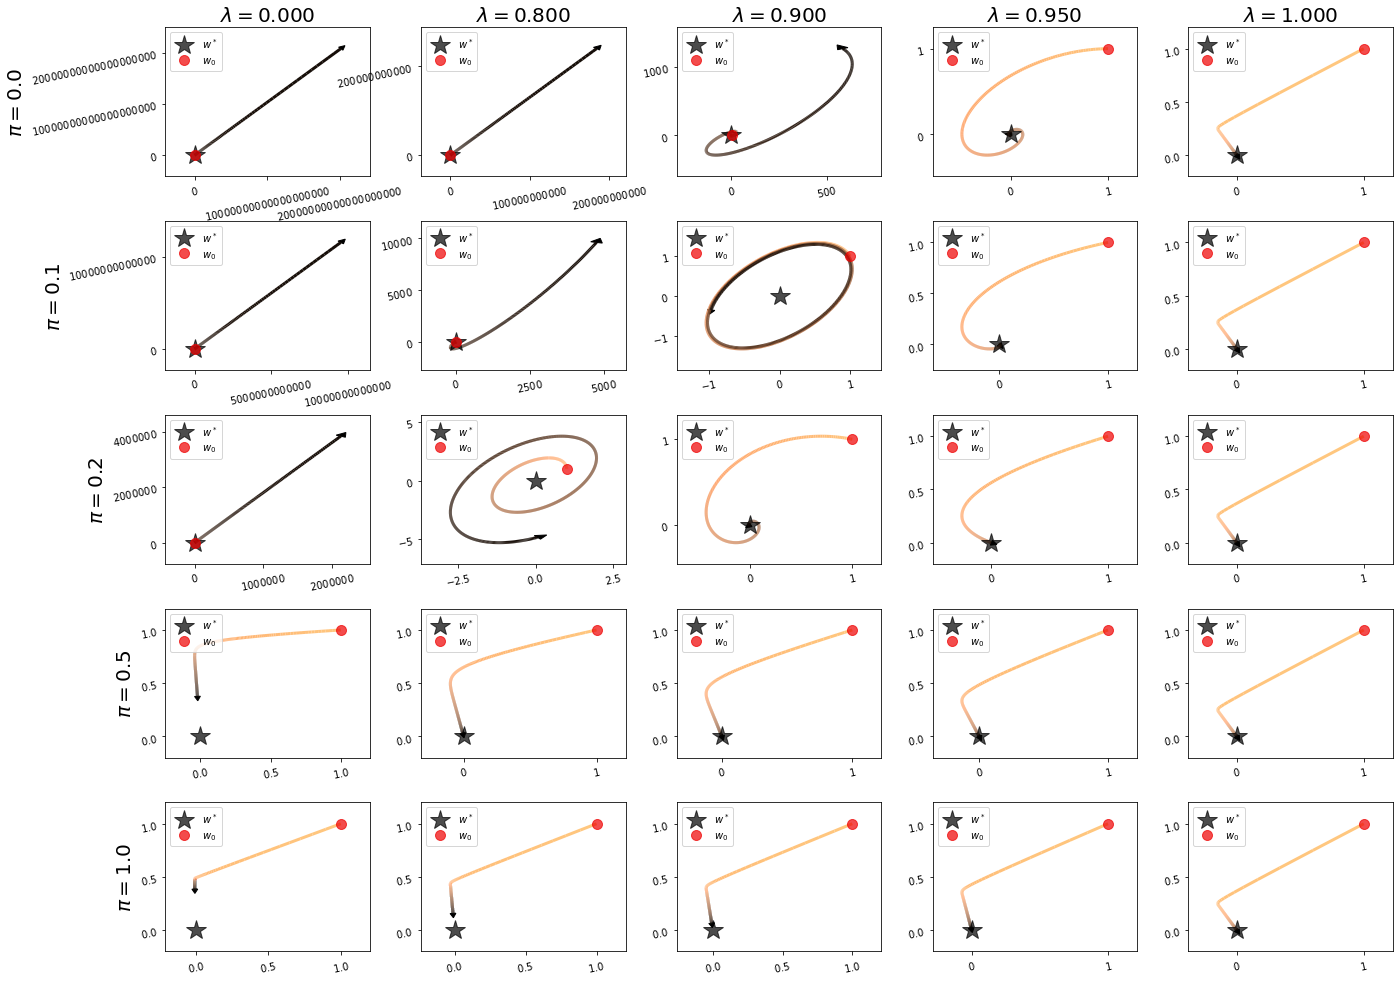

In [22]:
def generate_ws(w, pi, mu, l, g):
  """Apply the expected update 1000 times"""
  ws = [w]
  for _ in range(1000):
    w = w + expected_update(w, pi, mu, l, g, lr=0.1)
    ws.append(w)
  return np.array(ws)

mu = 0.5  # behaviour
g = 0.99  # discount

lambdas = np.array([0, 0.8, 0.9, 0.95, 1.])
pis = np.array([0., 0.1, 0.2, 0.5, 1.])

fig = plt.figure(figsize=(22, 17))
fig.subplots_adjust(wspace=0.25, hspace=0.3)

for r, pi in enumerate(pis):
  for c, l in enumerate(lambdas):
    plt.subplot(len(pis), len(lambdas), r*len(lambdas) + c + 1)
    w = np.ones_like(x1)
    ws = generate_ws(w, pi, mu, l, g)
    title = '$\\lambda={:1.3f}$'.format(l) if r == 0 else None
    ylabel = '$\\pi={:1.1f}$'.format(pi) if c == 0 else None
    plotting_helper_function(ws[:, 0], ws[:, 1], title, ylabel)

## Q9: Analyse results (30 pts total)
1. **[2 pts]** How many of the above 25 experiments diverge?
1. **[4 pts]** Why are the results asymmetric across different $\pi$?  In particular, explain why the results look different when comparing $\pi = \pi(a | \cdot) = 0$ to $\pi(a | \cdot) = 1$.
1. **[4 pts]** For which policies $\pi$, is the true value function $v_{\pi}$ representable in the above feature space (spanned by $x_1, x_2$).
1. **[4 pts]** For which combination of $\pi(a)$ and $\lambda$ does the expected update (with uniform random behaviour) converge? (Do not limit the answer to the subset of values in the plots above, but to all choices of $\lambda$ and $\pi$, but do restrict yourself to state-less policies, as above, for which the action probabilities are equal in the two states.)
1. **[4 pts]** Why do all the plots corresponding to full Monte Carlo look the same?
1. **[4 pts]** Why do the plots corresponding to full Monte Carlo have the shape they do?
1. **[4 pts]** How would the results above change (at high level, not in terms of precise plots) if the behaviour policy $\mu$ would select action $a$ more often (e.g., $\mu = 0.8$)?  How would the results change if the behaviour would select $a$ less often (e.g., $\mu = 0.2$)?
1. **[4 pts]** Consider again the orginal experiment, where data is gathered under uniformly random behaviour policy. What would the updates to the vectors $w$ be under the $L_\infty$ norm? You can either run the experiment or give the closed-form update in an equation.


## Put answers to Q9 in this cell:

Key equations:

Value function
$$
  v(w,x) = w^Tx
$$

Off-policy-corrected lambda-return
$$
  G_t^{\rho \lambda} = \frac
  {\gamma (1 - \lambda) (\pi v(w, x_1) + (1 - \pi) v(w, x_2))}
  {1 - \lambda \gamma}
$$
Expected weight update
$$
  \Delta w = \alpha (\mu(G_t^{\rho \lambda} - v(w, x_1))x_1 + 
  (1 - \mu)(G_t^{\rho \lambda} - v(w, x_2))x_2)
$$

1. 7 out of 25 explicitly diverge, with one experiment with $\lambda = 0.9$ and $\pi=0.1$ circling the optimal value. This circuling value should converge to the optimal value as $t \to \infty$.

2. The target policy $\pi$ has an effect on the relative weight of each state in the expectation of $G_t^{\rho \lambda}$. Higher values of $\pi$ lead to $x_1$ having a larger impact on $G_t^{\rho \lambda}$, with lower $\pi$ values leading to $x_2$ having a larger impact. When $\pi=1$, only $x_1$ has an impact as there is a zero probability of $x_2$ being in the target policy. Whereas When $\pi=0$, only $x_2$ has an impact on the expected value. Thus when $\pi$ is small, we see $G_t^{\rho \lambda}$ is larger, meaning that is more likely to be larger than $v(w,x_1)$ and  $v(w,x_2)$. If $G_t^{\rho \lambda}$ is larger than $v(w,x_1)$ and  $v(w,x_2)$, then the policy will diverge as the update will be positive. We can further see that for higher values of $\pi$ convergence, generally take a more direct route. 

3. $v_{\pi}$ is representable for all policies in the feature space spanned by $x_1, x_2$. The weights for the true value fucntion are $w=[0,0]$. We can see this as for $\lambda=1$, all policies will converge to the true policy as $t \to \infty$.

4. The weights update equation ($\Delta w = [\Delta w_1, \Delta w_2]^T$) with $\mu=1/2$ and $x_1 = [1,1]^T$, $x_2 = [2,1]^T$, can be expressed as:
$$
  \Delta w = \begin{bmatrix}
    \Delta w_1 \\
    \Delta w_2
  \end{bmatrix}
   = \frac{\alpha}{2} \left(
  \begin{bmatrix}
    3 G_t^{\rho \lambda} \\
    2 G_t^{\rho \lambda}
  \end{bmatrix}
  -
  \begin{bmatrix}
    5 w_1 + 3 w_2  \\
    3 w_1 + 2 w_2
  \end{bmatrix}
  \right)
$$
Rearanging:
$$
  \begin{bmatrix}
    \Delta w_1 \\
    \Delta w_2
  \end{bmatrix}
   = \frac{\alpha}{2} \left(
  \begin{bmatrix}
    3 G_t^{\rho \lambda} \\
    2 G_t^{\rho \lambda}
  \end{bmatrix}
  -
  \begin{bmatrix}
    5 & 3  \\
    3 & 2
  \end{bmatrix}
  \begin{bmatrix}
    w_1  \\
    w_2
  \end{bmatrix}
  \right)
$$
Inspecting our $G_t^{\rho \lambda}$ term and substituting $\beta=\frac
  {\gamma (1 - \lambda)}{1 - \lambda \gamma}$.
$$
  \begin{bmatrix}
    3 G_t^{\rho \lambda} \\
    2 G_t^{\rho \lambda}
  \end{bmatrix} = 
  \begin{bmatrix}
    3 \beta \left(\pi (w_1 + w_2) + (1 - \pi)(2w_1 + w_2) \right) \\
    2 \beta \left(\pi (w_1 + w_2) + (1 - \pi)(2w_1 + w_2) \right)
  \end{bmatrix} = 
  \begin{bmatrix}
    3 \beta (2 w_1 - \pi w_1) & 3 \beta w_2  \\
    2 \beta (2 w_1 - \pi w_1) & 2 \beta w_2
  \end{bmatrix} = 
  \begin{bmatrix}
    3 \beta (2 - \pi) & 3 \beta  \\
    2 \beta (2 - \pi) & 2 \beta
  \end{bmatrix}
  \begin{bmatrix}
    w_1 \\
    w_2
  \end{bmatrix}
$$
Substituing this in to our equation:
$$
  \begin{bmatrix}
    \Delta w_1 \\
    \Delta w_2
  \end{bmatrix}
   = \frac{\alpha}{2} \left(
  \begin{bmatrix}
    3 \beta (2 - \pi) & 3 \beta  \\
    2 \beta (2 - \pi) & 2 \beta
  \end{bmatrix}
      \begin{bmatrix}
    w_1 \\
    w_2
  \end{bmatrix}
  -
  \begin{bmatrix}
    5 & 3  \\
    3 & 2
  \end{bmatrix}
  \begin{bmatrix}
    w_1  \\
    w_2
  \end{bmatrix}
  \right)
$$
$$
  \begin{bmatrix}
    \Delta w_1 \\
    \Delta w_2
  \end{bmatrix}
   = \frac{\alpha}{2} \left(
  \begin{bmatrix}
    3 \beta (2 - \pi) - 5 & 3 \beta - 3  \\
    2 \beta (2 - \pi) - 3 & 2 \beta - 2
  \end{bmatrix}
      \begin{bmatrix}
    w_1 \\
    w_2
  \end{bmatrix}
  \right)
$$
This is of the same format, $\Delta w = - \alpha A w$ where $A$ is, 
$$
  A = 
  \frac{1}{2}
  \begin{bmatrix}
    3 \beta (\pi - 2) + 5 & -3 \beta + 3  \\
    2 \beta (\pi - 2) + 3 & -2 \beta + 2
  \end{bmatrix}
$$
We can see that for w to converge we must have that $A$ is positive deffinite, which we can guerentee if $||A|| > 0$ and $trace(A) > 0$. The determinant is: 
$$
  ||A|| = \frac{1}{4} (1 - \beta)
$$
We can see that the determinent of A is always greater than 0 as $0<\beta < 1$. Thus examining the trace: 
$$
  trace(A) = \frac{1}{2} \left( 
    (3 \beta (\pi - 2) + 5) + (-2 \beta + 2) \right) =
    \frac{1}{2}( 3 \beta \pi - 8 \beta + 7)
$$
$$
  trace(A) = 1.5 \beta \pi - 4 \beta + 3.5 = \beta(1.5 \pi - 4) + 3.5
$$
Thus the the trace is greater than zero then $\beta(1.5 \pi - 4) + 3.5 > 0$. Substituting our value for $\beta=\frac{\gamma (1 - \lambda)}{1 - \lambda \gamma}$:
$$
  \frac{\gamma (1 - \lambda)}{1 - \lambda \gamma} (1.5 \pi - 4) + 3.5 > 0
$$
We can see which of the $\lambda$-$\pi$ values satisfy these constraints in the code block below. 

5. Monte Carlo corresponds to $\lambda=1.0$. Here the equation reduces to:
$$
  G_t^{\rho \lambda} = 0
$$
$$
  \Delta w = - \alpha (\mu v(w, x_1)x_1 +
  ((1 - \mu) v(w, x_2)x_2))
$$
Thus all updates are the same for the Monte-Carlo case.

6. Using the above-derived equation for the Monte-Carlo case, we can see that the update for $\mu=0.5$ is:
$$
  \Delta w = \begin{bmatrix}
    \Delta w_1 \\
    \Delta w_2
  \end{bmatrix}
   = \frac{-\alpha}{2} \left(
  \begin{bmatrix}
    5 w_1 + 3 w_2  \\
    3 w_1 + 2 w_2
  \end{bmatrix}
  \right)
$$
Thus we can see that we move along the principal axis quicker when the weights are postive, leading to a faster convergence on the x-axis. This value slightly overshoots the true value leading to the weight increasing slightly. This is why we see the almost 90 degrees turn around x=0. 

7. The values of $G_t^{\rho \lambda}$ would remain unchanged, but increasing $\mu$ would lend greater weight to the update coming from the $x_1$ state. The increased weight for the $x_1$ update may straighten the path taken to the optimal policy as $x_1$ has a value of $[1,1]$. Similarly, decreasing $\mu$ would lead to $x_2$, having a more significant impact on updates. Thus, the update would move quickly along the x-axis, overshooting the optimal policy and circling back on itself. We can see from the plots below that decreasing $\mu$ actually increases the likelihood of convergence. Following a similar format to 9.4 we can see below the full equation for $\Delta w$. We can see that increasing $\mu$ has an affect of making the constaints on the matrix $A$ harder to furfill, thus decreasing the likihood of convergence.
$$
\begin{bmatrix}
    \Delta w_1 \\
    \Delta w_2
  \end{bmatrix}
   = \alpha \left(
  \begin{bmatrix}
    G_t^{\rho \lambda} - 4 w_1 + 2 w_2 - \mu(G + 4 w_1 - w_2)\\
    G_t^{\rho \lambda} - 2 w_1 - w_2 - \mu w_1
  \end{bmatrix}
  \right)
  = \alpha \left(
  \begin{bmatrix}
    G_t^{\rho \lambda} - 4 w_1 + 2 w_2 \\
    G_t^{\rho \lambda} - 2 w_1 - w_2
  \end{bmatrix}
  -   
  \begin{bmatrix}
    \mu(G^{\rho \lambda}_t + 4 w_1 - w_2)\\
    \mu w_1
  \end{bmatrix}
  \right)
$$


8. We have that the loss is:
$$
  L_w(x) =  ||G^{\rho \lambda}_t - w^T x||_{\infty} = \max_i|G - w^T x_i|
$$
Or in full, 
$$
  L_w(x) =  || [ G^{\rho \lambda}_t - w^T x_1, G^{\rho \lambda}_t - w^T x_2] ||_{\infty}
$$
The derivative of this is:
$$
  \nabla_w L_w(x) = - \sum_j sign(G - w^T x_j) x_j \delta_{k, j} 
$$
Where $\delta_{k,j}$ is the Kronecker delta which takes the value 1 at the maximmum absolute value and zero otherwise. Thus we see the update is:
$$
  k = \arg \max_i|G - w^T x_i|
$$
$$
  \Delta w = \alpha \cdot \sum_j sign(G - w^T x_j) \cdot x_j \cdot \delta_{k, j} 
$$
The resulting plots can be seen below. 




### Plots for Q9

**Tests for 9.4**

In [23]:
def nine_point_4(pi, l, gamma):

  beta = (gamma * (1 - l))/(1 - l * gamma)

  if beta * (1.5 * pi - 4) + 3.5 > 0:
    print("Expected update should converge for pi = {} and lambda = {}".format(pi, l))

g = 0.99  # discount

lambdas = np.array([0, 0.8, 0.9, 0.95, 1.])
pis = np.array([0., 0.1, 0.2, 0.5, 1.])

for r, pi in enumerate(pis):
  for c, l in enumerate(lambdas):
    nine_point_4(pi, l, g)

Expected update should converge for pi = 0.0 and lambda = 0.95
Expected update should converge for pi = 0.0 and lambda = 1.0
Expected update should converge for pi = 0.1 and lambda = 0.9
Expected update should converge for pi = 0.1 and lambda = 0.95
Expected update should converge for pi = 0.1 and lambda = 1.0
Expected update should converge for pi = 0.2 and lambda = 0.9
Expected update should converge for pi = 0.2 and lambda = 0.95
Expected update should converge for pi = 0.2 and lambda = 1.0
Expected update should converge for pi = 0.5 and lambda = 0.0
Expected update should converge for pi = 0.5 and lambda = 0.8
Expected update should converge for pi = 0.5 and lambda = 0.9
Expected update should converge for pi = 0.5 and lambda = 0.95
Expected update should converge for pi = 0.5 and lambda = 1.0
Expected update should converge for pi = 1.0 and lambda = 0.0
Expected update should converge for pi = 1.0 and lambda = 0.8
Expected update should converge for pi = 1.0 and lambda = 0.9
Expe

**Plots for 9.7**

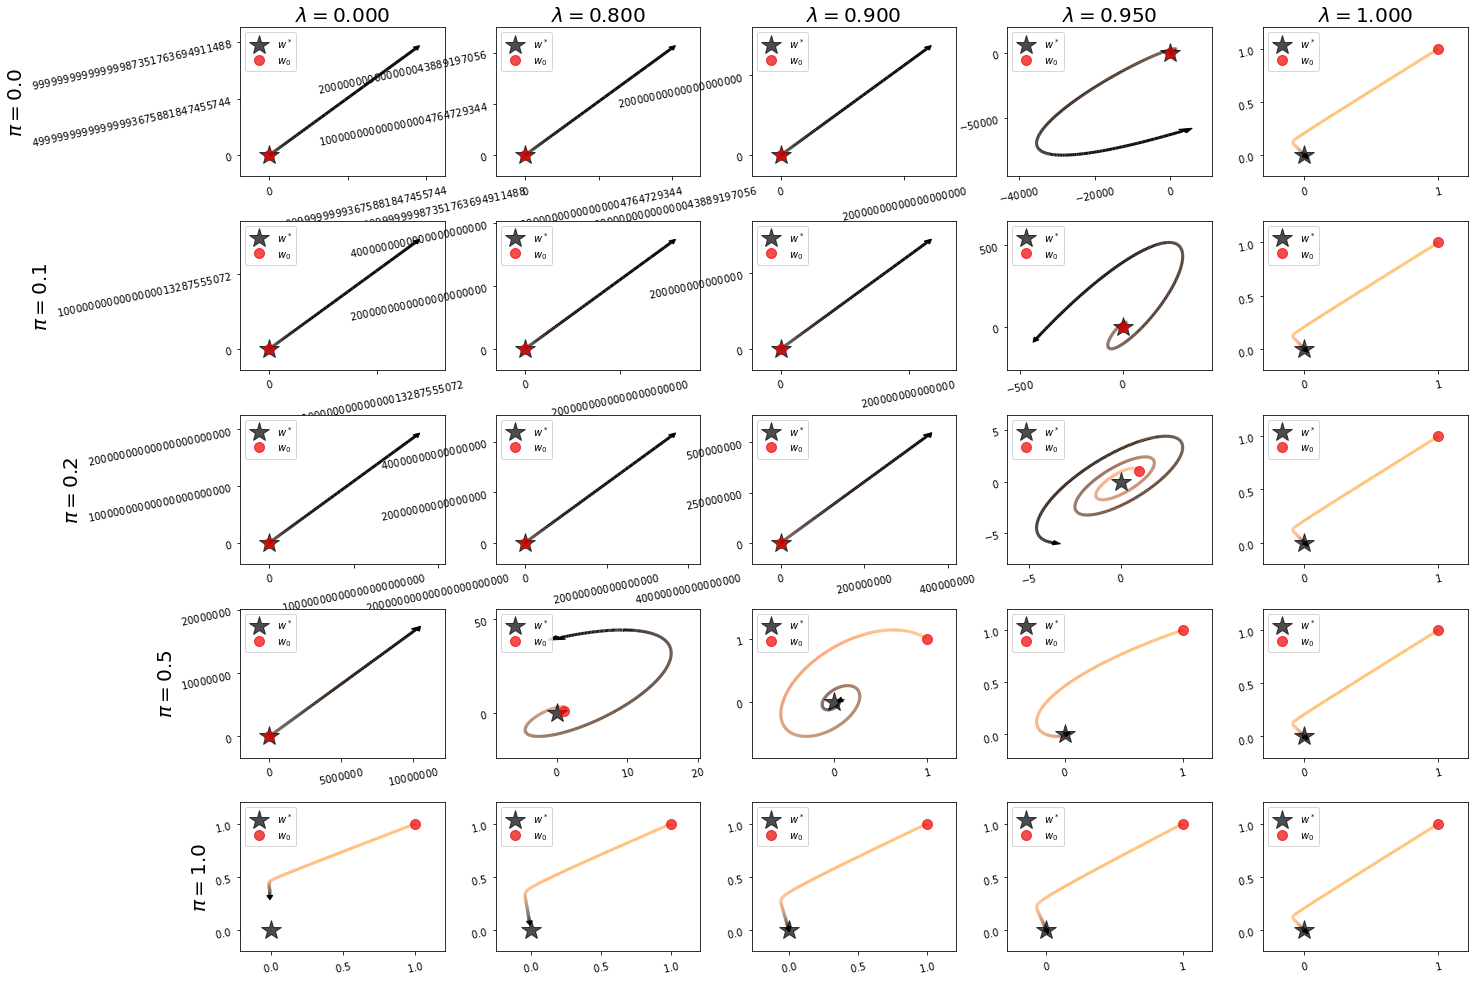

In [24]:
mu = 0.8  # behaviour
g = 0.99  # discount

lambdas = np.array([0, 0.8, 0.9, 0.95, 1.])
pis = np.array([0., 0.1, 0.2, 0.5, 1.])

fig = plt.figure(figsize=(22, 17))
fig.subplots_adjust(wspace=0.25, hspace=0.3)

for r, pi in enumerate(pis):
  for c, l in enumerate(lambdas):
    plt.subplot(len(pis), len(lambdas), r*len(lambdas) + c + 1)
    w = np.ones_like(x1)
    ws = generate_ws(w, pi, mu, l, g)
    title = '$\\lambda={:1.3f}$'.format(l) if r == 0 else None
    ylabel = '$\\pi={:1.1f}$'.format(pi) if c == 0 else None
    plotting_helper_function(ws[:, 0], ws[:, 1], title, ylabel)

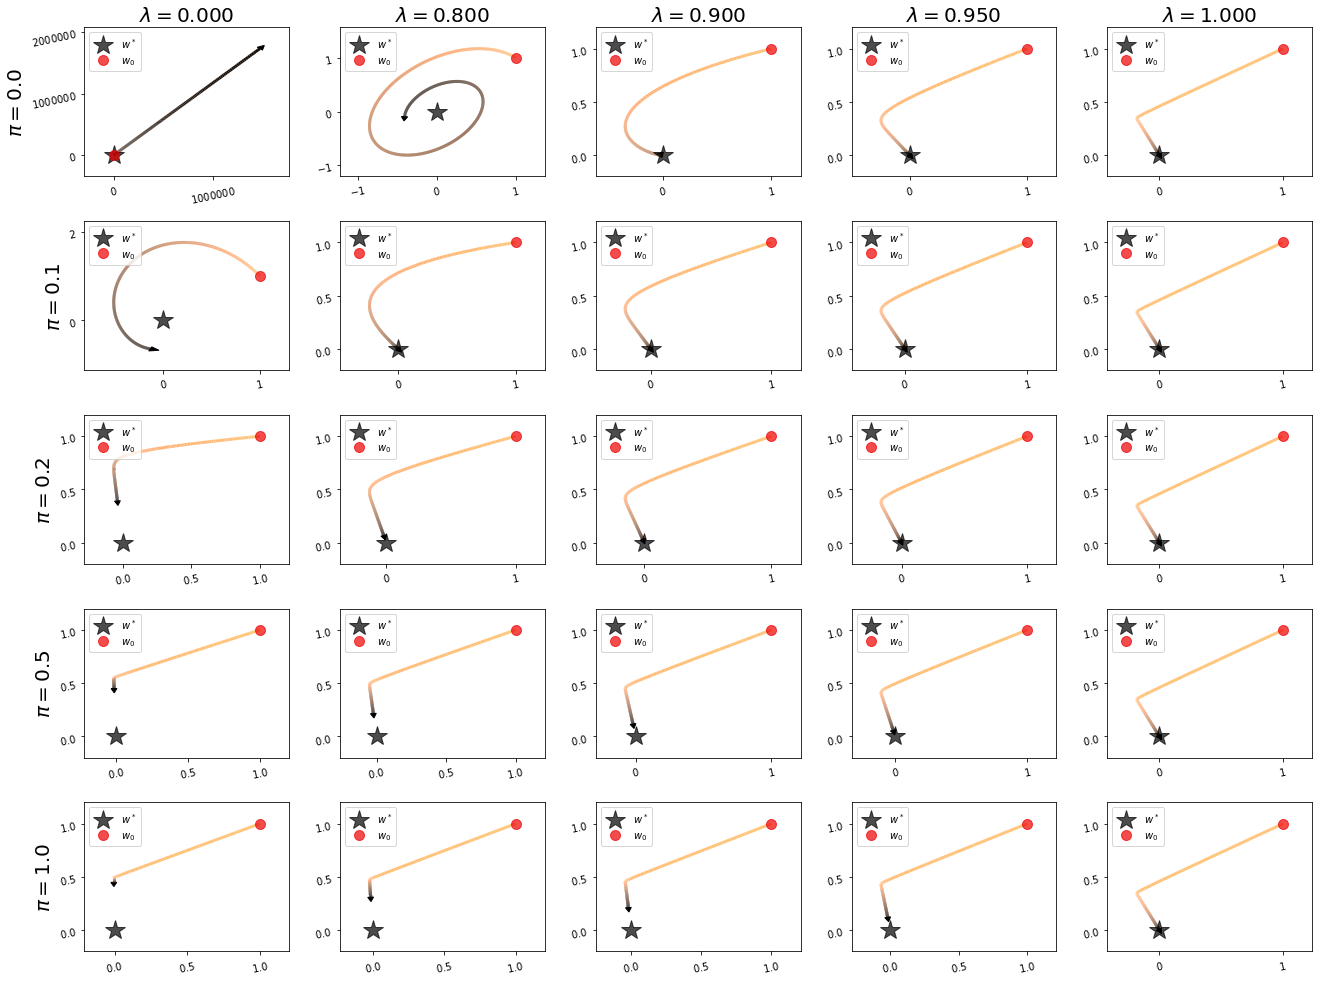

In [25]:
mu = 0.2  # behaviour
g = 0.99  # discount

lambdas = np.array([0, 0.8, 0.9, 0.95, 1.])
pis = np.array([0., 0.1, 0.2, 0.5, 1.])

fig = plt.figure(figsize=(22, 17))
fig.subplots_adjust(wspace=0.25, hspace=0.3)

for r, pi in enumerate(pis):
  for c, l in enumerate(lambdas):
    plt.subplot(len(pis), len(lambdas), r*len(lambdas) + c + 1)
    w = np.ones_like(x1)
    ws = generate_ws(w, pi, mu, l, g)
    title = '$\\lambda={:1.3f}$'.format(l) if r == 0 else None
    ylabel = '$\\pi={:1.1f}$'.format(pi) if c == 0 else None
    plotting_helper_function(ws[:, 0], ws[:, 1], title, ylabel)

**Plots for 9.8**

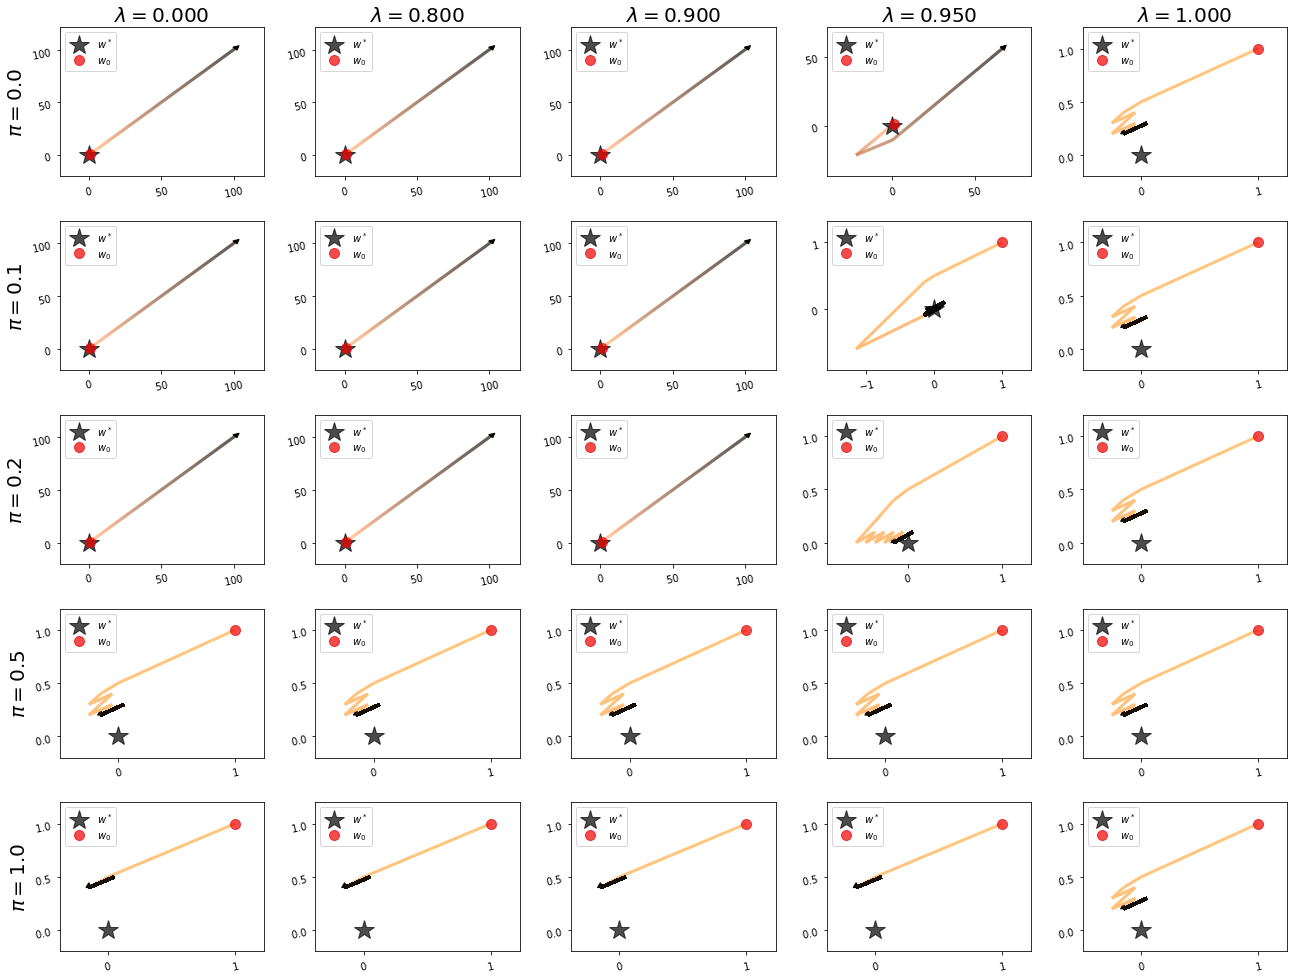

In [26]:
def l_inf_expected_update(w, pi, mu, l, g, lr):
  
  G = T(w, pi, mu, l, g)

  # update = mu * np.sign(G - v(w, x1)) * x1 + (1 - mu) * np.sign(G - v(w, x2)) * x2
  # update = lr * update

  # Alternate
  if abs(G - v(w, x1)) > abs(G - v(w, x2)):
    update = np.sign(G - v(w, x1)) * x1
  elif abs(G - v(w, x1)) < abs(G - v(w, x2)):
    update = np.sign(G - v(w, x2)) * x2
  else: 
    update = mu * np.sign(G - v(w, x1)) * x1 + (1 - mu) * np.sign(G - v(w, x2)) * x2

  return lr * update

def l_inf_generate_ws(w, pi, mu, l, g):
  """Apply the expected update 1000 times"""
  ws = [w]
  for _ in range(1000):
    w = w + l_inf_expected_update(w, pi, mu, l, g, lr=0.1)
    ws.append(w)
  return np.array(ws)

mu = 0.5  # behaviour
g = 0.99  # discount

lambdas = np.array([0, 0.8, 0.9, 0.95, 1.])
pis = np.array([0., 0.1, 0.2, 0.5, 1.])

fig = plt.figure(figsize=(22, 17))
fig.subplots_adjust(wspace=0.25, hspace=0.3)

for r, pi in enumerate(pis):
  for c, l in enumerate(lambdas):
    plt.subplot(len(pis), len(lambdas), r*len(lambdas) + c + 1)
    w = np.ones_like(x1)
    ws = l_inf_generate_ws(w, pi, mu, l, g)
    title = '$\\lambda={:1.3f}$'.format(l) if r == 0 else None
    ylabel = '$\\pi={:1.1f}$'.format(pi) if c == 0 else None
    plotting_helper_function(ws[:, 0], ws[:, 1], title, ylabel)